# Creating Saliency Maps for CNNs with `LIME`

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Explainable AI** (**XAI**), or **Interpretable AI**, or **Explainable Machine Learning** (**XML**), is AI in which the results of the solution can be understood by humans. It contrasts with the concept of the "[black box](https://en.wikipedia.org/wiki/Black_box "Black box")" in machine learning where even its designers cannot explain why an AI arrived at a specific decision.

One of the main ideas behind **Explainable AI** (XAI) is the moto that
"_complex systems (like neural networks) need to be interpretable to humans._" As a response to the concerns raised against model opacity, the field of interpretability (specifically in CV applications) has formed two major threads of response: **feature visualization** and **saliency mapping**. This notebook focuses on **saliency mapping techniques**. 

![image](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/images.png)

For a comprehensive explanation of the limitations and difficulties related to saliency mapping techniques, [we recommend this article](https://arxiv.org/abs/2002.00772), made by _[Ahmed Alqaraawi](https://arxiv.org/search/cs?searchtype=author&query=Alqaraawi%2C+A), [Martin Schuessler](https://arxiv.org/search/cs?searchtype=author&query=Schuessler%2C+M), [Philipp Weiß](https://arxiv.org/search/cs?searchtype=author&query=Wei%C3%9F%2C+P), [Enrico Costanza](https://arxiv.org/search/cs?searchtype=author&query=Costanza%2C+E), [Nadia Berthouze](https://arxiv.org/search/cs?searchtype=author&query=Berthouze%2C+N)_.

For a complete guide on ML Explainability, we recommend "_[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)_" (by _Christoph Molnar_).

In this notebook, we will be interpreting a CNN trained on the ***Cats vs Dogs dataset***, i.e., [a large set of images of cats and dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).



In [1]:
import lime
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from keras import models
import matplotlib.pyplot as plt

**The training of a CNN is outside the scope of this notebook. So, we are just gonna upload a pre-trained model. You can find loads of tutorials on how to train a CNN in the literature, like in [_Deep Learning with Python_](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf), an d in this [notebook](CNN_model_maker.ipynb).**


In [3]:
model = tf.keras.models.load_model('models\pre_trained_cats_vs_dogs.h5')
model.trainable = False

**To visualize the arquitecture of a neural network, if you are using `Keras` or `Tensorflow` (librarys used to create the CNNs used in this notebook), you can use the `visualkeras` package.**

```python

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

```


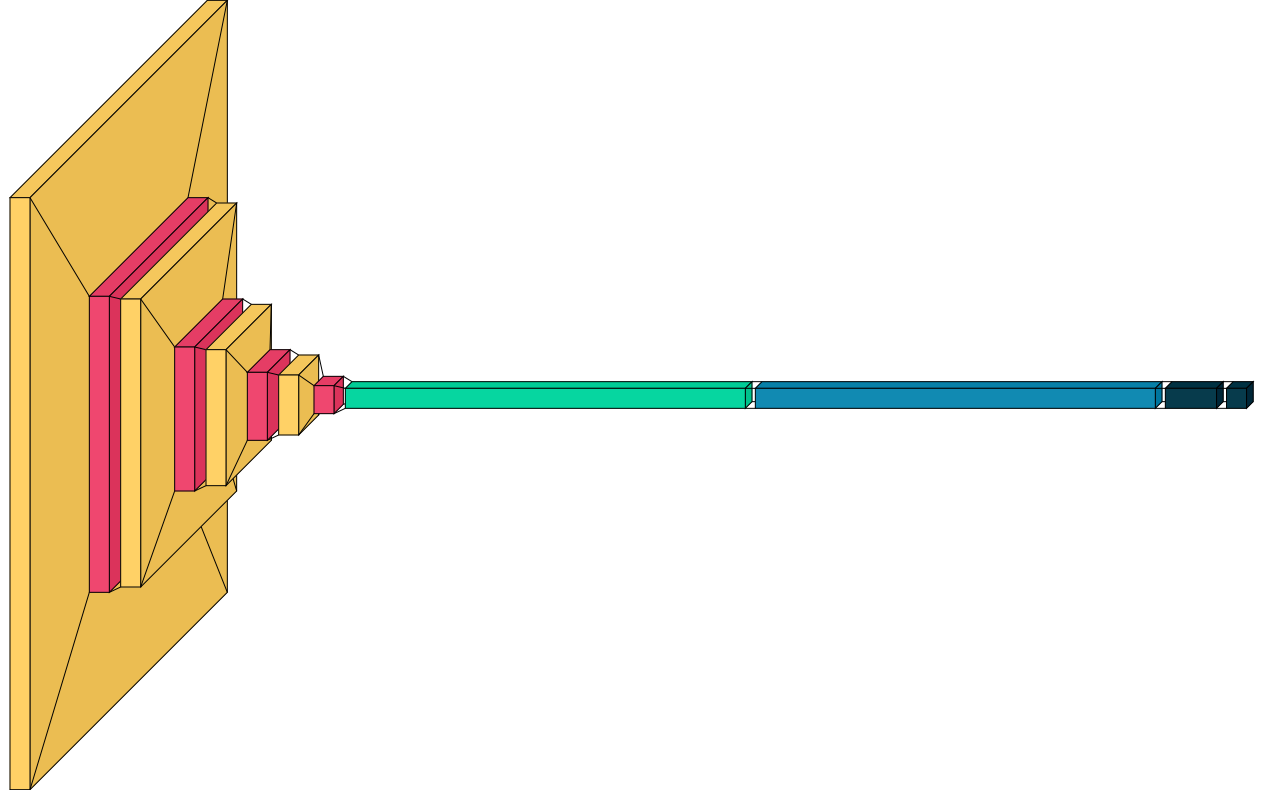

In [4]:
import visualkeras

visualkeras.layered_view(model)

**Let's now test our classification with some images.**

1/1 [==============================] - 3s 3s/step


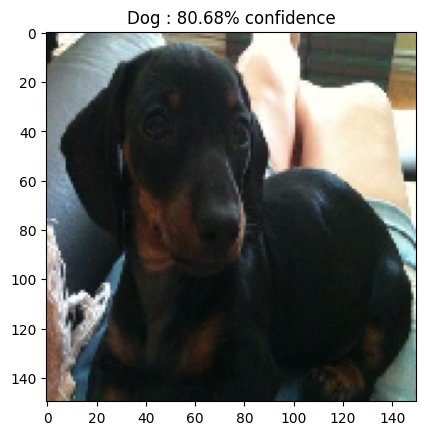

In [5]:
#img_path = r'samples\cat.jpg'
img_path = r'samples\tucassauros.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.


def get_image_label(img_tensor):
    prediction = model.predict(img_tensor)

    if prediction[0][0] <= 0.5:
        image_class = 1
        class_name = 'Cat'
        class_confidence = (1 - prediction[0][0]) * 100
        return image_class, class_name, class_confidence
    elif prediction[0][0] >= 0.5:
        image_class = 0
        class_name = 'Dog'
        class_confidence = prediction[0][0] * 100
        return image_class, class_name, class_confidence


plt.figure()
plt.imshow(img_tensor[0])
image_class, class_name, class_confidence = get_image_label(img_tensor)
plt.title('{} : {:.2f}% confidence'.format(class_name, class_confidence))
plt.show()

**To help us arrive at an understanding of the "why" of this classification, we will use the LIME methodology.** 🔎

### Local Interpretable Model-agnostic Explanations ([LIME](https://arxiv.org/abs/1602.04938?context=cs))

**Lime is an interpretability methodology proposed by [Marco Tulio Ribeiro](https://arxiv.org/search/cs?searchtype=author&query=Ribeiro%2C+M+T), [Sameer Singh](https://arxiv.org/search/cs?searchtype=author&query=Singh%2C+S), and [Carlos Guestrin](https://arxiv.org/search/cs?searchtype=author&query=Guestrin%2C+C).**

**The key idea behind it is to locally approximate a black-box model by a simpler glass-box model, which is easier to interpret. The method has been widely adopted in the text and image analysis, partly due to the interpretable data representation.**

![image](https://c3.ai/wp-content/uploads/2020/10/Lime1-500x270.png)

Source: _["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938?context=cs)_

**To create an "explainer" with the LIME library, we need to pass the following parameters:**

- **images** — _The image that we want LIME to explain._
- **classifier** — _Your image classier prediction function._
- **top_labels** — _The number of labels that you want LIME to show (2 will show Top 2)._
- **num_samples** — _to determine the amount of artificial data points similar to our._

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img_tensor[0].astype('double'), model.predict,
                                         top_labels=2, hide_color=0, num_samples=1000)


**The object created (`explanation`) has a method called `get_image_and_mask`, capable of generating an explanation (based on saliency maps) of the classification in question.**

(-0.5, 149.5, 149.5, -0.5)

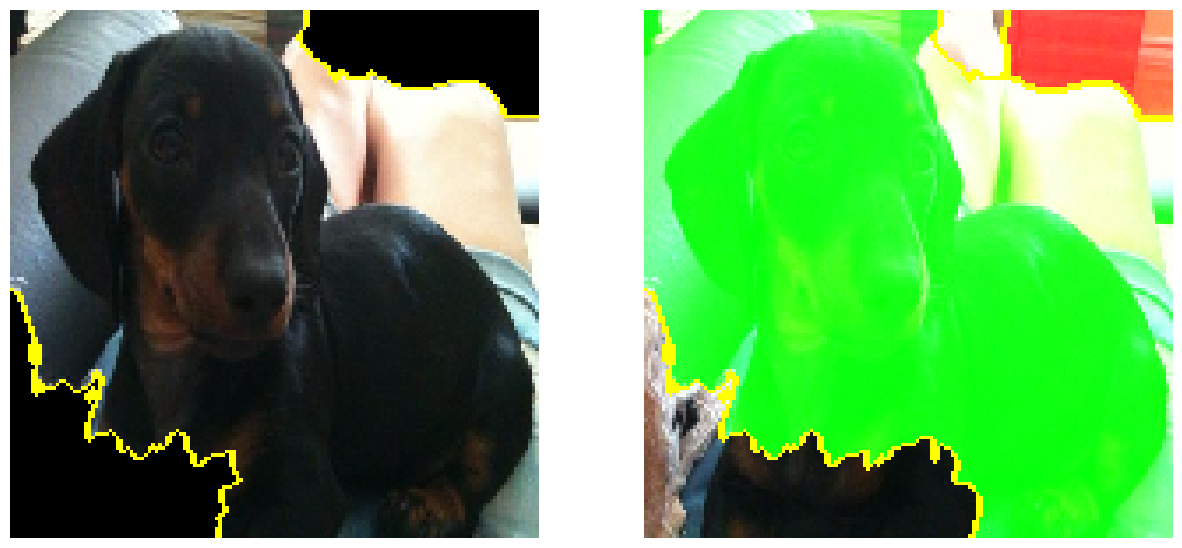

In [11]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=True)

temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


- **On the left image (`ax1`), we can see that only the super-pixels where "_cat-features_" are visible are shown. This means that our model classifies our image as a cat because of these parts of super-pixels**

- **On the right image (`ax2`), the area of super-pixels colored in green are the ones that increase the probability of our image belongs to the Cat class, while the super-pixels colored in red are the ones that decrease the probability.**

**Let's test this tool on another model!**

## `MobileNetV2`

**MobileNetV2** is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully [convolution](https://paperswithcode.com/method/convolution) layer with 32 filters, followed by 19 residual bottleneck layers.

![image](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)

**You can load this model directly from the (TF)Keras library, weights and all!** 🙃

14536120/14536120 [==============================] - 2s 0us/step


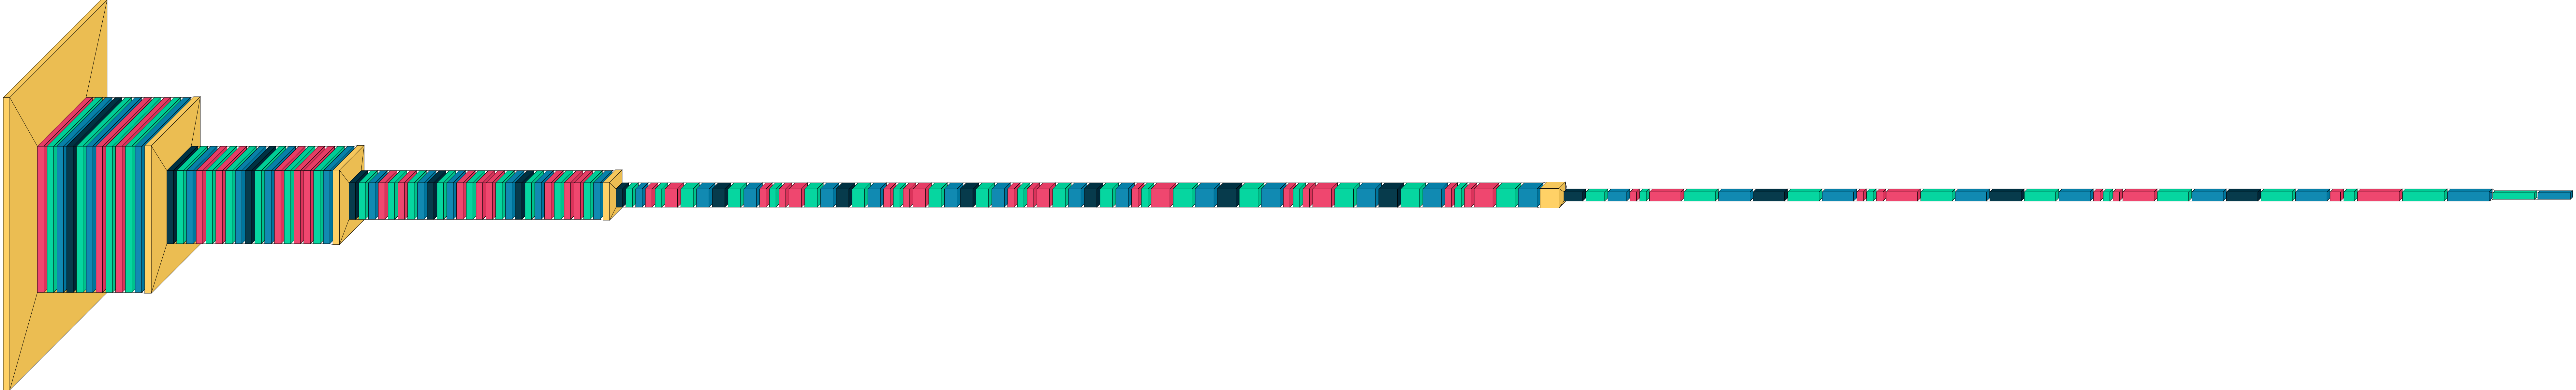

In [12]:
model = tf.keras.applications.MobileNetV2(include_top=True,
                                          weights='imagenet')
model.trainable = False

visualkeras.layered_view(model)


**Let's now test `MobileNetV2` with something less cute than cats and dogs...**

1/1 [==============================] - 0s 25ms/step


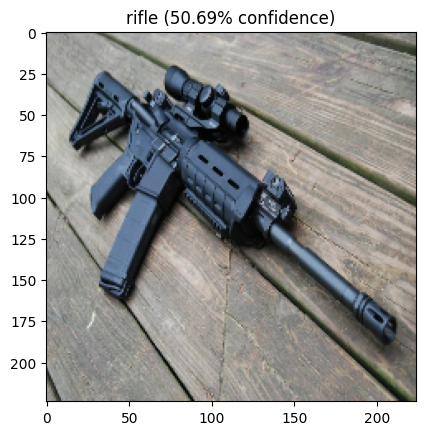

In [14]:

img_path = r'samples\rifle.jpg'

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions


def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image


def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]


image_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(image_raw)
img = preprocess(img)
image_probs = model.predict(img)
class_index = np.argmax(image_probs[0])

plt.figure()
plt.imshow(img[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} ({:.2f}% confidence)'.format(image_class, class_confidence*100))
plt.show()


**We will reuse the same method that we used before.**

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  1%|          | 10/1000 [00:01<02:03,  8.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 20/1000 [00:01<00:57, 17.04it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 30/1000 [00:01<00:36, 26.93it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 40/1000 [00:01<00:25, 37.03it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 50/1000 [00:01<00:20, 46.63it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 60/1000 [00:01<00:16, 55.44it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 70/1000 [00:01<00:14, 62.87it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 80/1000 [00:02<00:13, 68.75it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 90/1000 [00:02<00:12, 74.12it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 100/1000 [00:02<00:11, 77.19it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 110/1000 [00:02<00:11, 79.70it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 120/1000 [00:02<00:10, 82.70it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 130/1000 [00:02<00:10, 84.48it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 140/1000 [00:02<00:10, 85.36it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 150/1000 [00:02<00:09, 86.29it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 160/1000 [00:02<00:09, 86.51it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 170/1000 [00:03<00:09, 86.75it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 180/1000 [00:03<00:09, 86.28it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 190/1000 [00:03<00:09, 87.32it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 200/1000 [00:03<00:09, 87.83it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 210/1000 [00:03<00:08, 88.21it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 220/1000 [00:03<00:08, 88.23it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 230/1000 [00:03<00:08, 87.24it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 240/1000 [00:03<00:08, 87.36it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 250/1000 [00:03<00:08, 88.20it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 260/1000 [00:04<00:08, 88.36it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 270/1000 [00:04<00:08, 87.28it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 280/1000 [00:04<00:08, 87.37it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 290/1000 [00:04<00:08, 86.23it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 300/1000 [00:04<00:08, 86.90it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 310/1000 [00:04<00:07, 87.92it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 82.27it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 83.38it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 340/1000 [00:05<00:07, 84.08it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 350/1000 [00:05<00:07, 85.55it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 360/1000 [00:05<00:07, 85.43it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 370/1000 [00:05<00:07, 84.01it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 380/1000 [00:05<00:10, 61.48it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 68.30it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 400/1000 [00:05<00:08, 72.56it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 410/1000 [00:06<00:07, 77.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 420/1000 [00:06<00:07, 79.99it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 430/1000 [00:06<00:06, 82.56it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 440/1000 [00:06<00:06, 83.05it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 450/1000 [00:06<00:06, 84.28it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 460/1000 [00:06<00:06, 84.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 85.72it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 86.17it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 490/1000 [00:06<00:05, 87.11it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 500/1000 [00:07<00:05, 87.36it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 510/1000 [00:07<00:05, 87.11it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 520/1000 [00:07<00:05, 87.92it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 530/1000 [00:07<00:05, 88.30it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 540/1000 [00:07<00:05, 87.35it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 550/1000 [00:07<00:05, 86.57it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 86.32it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 570/1000 [00:07<00:04, 87.06it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 580/1000 [00:07<00:04, 87.59it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 590/1000 [00:08<00:04, 88.08it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 600/1000 [00:08<00:04, 88.28it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 610/1000 [00:08<00:04, 88.40it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 620/1000 [00:08<00:04, 88.08it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 630/1000 [00:08<00:04, 87.73it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 87.54it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 86.81it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 660/1000 [00:08<00:03, 86.94it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 670/1000 [00:08<00:03, 88.10it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 680/1000 [00:09<00:03, 87.79it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 690/1000 [00:09<00:03, 87.49it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 700/1000 [00:09<00:03, 87.04it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 710/1000 [00:09<00:03, 87.08it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 85.63it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 85.39it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 83.87it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 750/1000 [00:09<00:02, 84.92it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 760/1000 [00:10<00:02, 85.84it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 770/1000 [00:10<00:02, 85.40it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 780/1000 [00:10<00:02, 85.81it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 790/1000 [00:10<00:02, 85.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 800/1000 [00:10<00:02, 85.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 810/1000 [00:10<00:02, 85.00it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 86.00it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 84.49it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 86.11it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 850/1000 [00:11<00:01, 86.87it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 860/1000 [00:11<00:01, 86.53it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 870/1000 [00:11<00:01, 86.30it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 86.88it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 86.25it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 86.55it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 86.59it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 920/1000 [00:11<00:00, 85.91it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 930/1000 [00:12<00:00, 85.42it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 940/1000 [00:12<00:00, 85.76it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 85.97it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 84.31it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 85.02it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 85.93it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 85.44it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 1000/1000 [00:12<00:00, 77.91it/s]


(-0.5, 223.5, 223.5, -0.5)

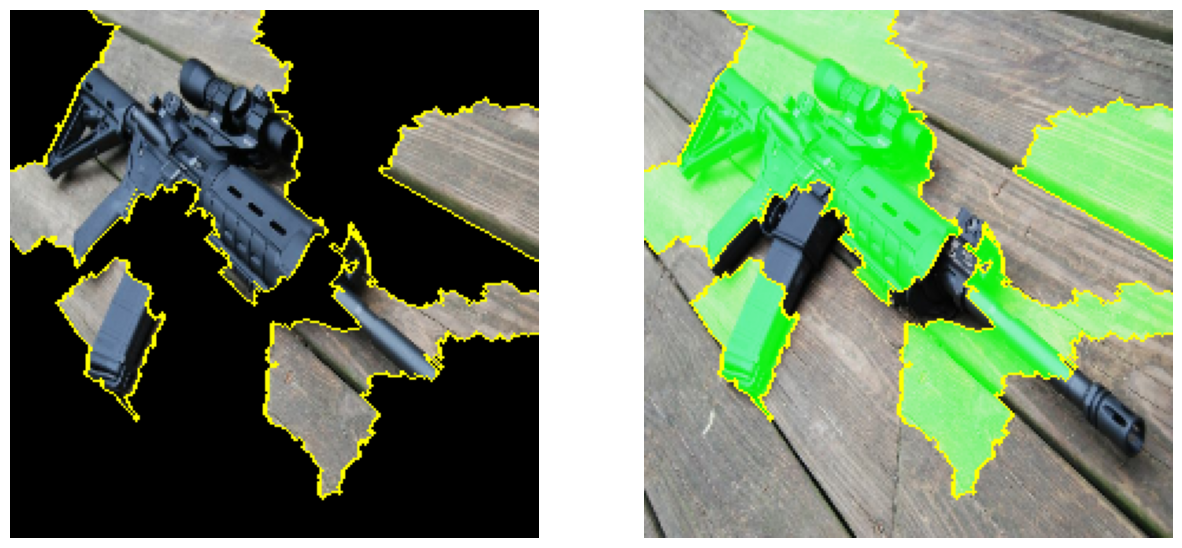

In [15]:

explainer = lime_image.LimeImageExplainer()


explanation = explainer.explain_instance((np.array(img)[0] * 0.5 + 0.5).astype('double'), model.predict,
                                         top_labels=10, hide_color=0, num_samples=1000)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=True)

temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


**The LIME methodology is a useful tool for developers seeking to understand and explain the behavior of black-box models. And now you know how to use LIME in CV! 🙃**

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
